In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [190]:
df = pd.DataFrame(pd.read_csv('../data/raw/student-mat.csv', sep=';'))

### 숫자형 아닌 컬럼을 숫자형으로 바꾸거나 drop해야 함

In [191]:
# 숫자형이 아닌 속성들 확인
# 어떤 값들로 이루어져 있는진 사이트의 데이터 설명참조함
df.select_dtypes(include=['object']).nunique()

school        2
sex           2
address       2
famsize       2
Pstatus       2
Mjob          5
Fjob          5
reason        4
guardian      3
schoolsup     2
famsup        2
paid          2
activities    2
nursery       2
higher        2
internet      2
romantic      2
dtype: int64

### Str타입인 address를 &rarr; boolean타입인 fromCity으로 변환

In [192]:
df['address'].unique()

array(['U', 'R'], dtype=object)

In [193]:
# fromCity 컬럼 추가
df.insert(1, "fromCity", df['address'].apply(lambda x: 1 if x == 'U' else 0))

# address 컬럼 삭제
df.drop(columns=['address'], inplace=True)

df.head()

,school,fromCity,sex,age,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,1,F,18,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,1,F,17,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,1,F,15,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,1,F,15,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,1,F,16,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### 도시학교(GP)와 시골학교(MS) 간 인원수 차이가 큼 &rarr; 시골학교(MS)인 학생들 제거 후 필요없어진 school 컬럼도 제거
- 한 데이터셋으로 두면 데이터 편향 생김
- 언더 or 오버 샘플링 미고려
- 각 학교별 성격이 다름. 시험 채점 방식도 다를 수 있음.

In [194]:
df['school'].unique()

array(['GP', 'MS'], dtype=object)

In [195]:
# 학교별로 나누고 school 컬럼
gp_df = df[df['school'] == 'GP']
ms_df = df[df['school'] == 'MS']
gp_df = gp_df.drop(columns=['school'])
ms_df = ms_df.drop(columns=['school'])

print(f'총합: {len(df)}, 도시학교: {len(gp_df)}, 시골학교: {len(ms_df)}')

총합: 395, 도시학교: 349, 시골학교: 46


In [196]:
print(f'도시학교: {gp_df['fromCity'].value_counts()}, \n\n시골학교: {ms_df['fromCity'].value_counts()}')

도시학교: fromCity
1    286
0     63
Name: count, dtype: int64, 

시골학교: fromCity
0    25
1    21
Name: count, dtype: int64


### Str타입인 성별을 numeric으로

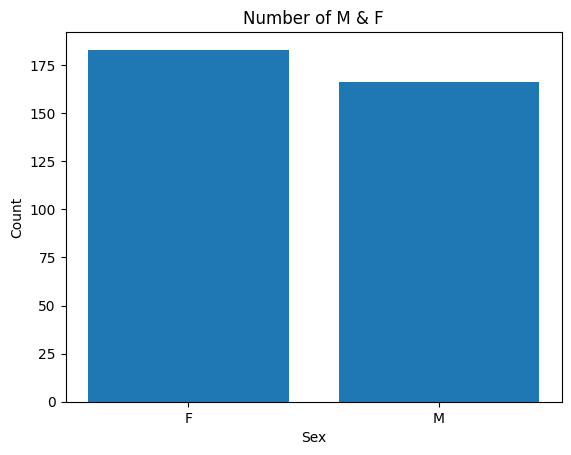

In [197]:
# 막대그래프로 표시
counts = gp_df['sex'].value_counts()

plt.bar(counts.index, counts.values)
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Number of M & F")
plt.show()

##### female은 0 male은 1임

In [198]:
from sklearn.preprocessing import LabelEncoder
print(gp_df['sex'][0])
# str 성별 -> numeric 성별
encoder = LabelEncoder()
gp_df['sex'] = encoder.fit_transform(gp_df['sex'])
gp_df['sex'].dtypes, gp_df['sex'][0]


F


(dtype('int64'), np.int64(0))

### famsize는 가족구성원이 3명보다 많으면 GT3, 적으면 LE3 임 &rarr; T/F인 famMore3 로 변환 

##### famisize를 숫자형으로 바꾸고 컬럼명을 famMore3로 rename

In [199]:
gp_df['famsize'] = gp_df['famsize'].apply(lambda x: 1 if x == 'GT3' else 0)
gp_df.rename(columns={'famsize': 'famMore3'}, inplace=True)
gp_df.head(2)

,fromCity,sex,age,famMore3,Pstatus,Medu,Fedu,Mjob,Fjob,reason,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,A,4,4,at_home,teacher,course,...,4,3,4,1,1,3,6,5,6,6
1,1,0,17,1,T,1,1,at_home,other,course,...,5,3,3,1,1,3,4,5,5,6


### Pstatus컬럼의 A는 부모랑 떨어져 사는거, T는 같이 사는걸 의미 &rarr; liveTogether로 바꿈

In [200]:
gp_df['Pstatus'] = gp_df['Pstatus'].apply(lambda x: 1 if x == 'T' else 0)
gp_df.rename(columns={'Pstatus': 'liveTogether'}, inplace=True)
gp_df['liveTogether'].head()

0    0
1    1
2    1
3    1
4    1
Name: liveTogether, dtype: int64

### guardian는 mother, father, other. mother과 father 중 하나만 골라야해서 의미가 모호함(이혼가정인지 모름) &rarr; guardian 컬럼은 제거

In [201]:
print(gp_df['guardian'].value_counts())

gp_df['guardian'] = gp_df['guardian'].apply(lambda x: 1 if x == 'other' else 0)
gp_df.rename(columns={'guardian': 'noParent'}, inplace=True)

guardian
mother    245
father     78
other      26
Name: count, dtype: int64


### 결손치가 없는 것 같지만 0으로 표기돼있음.
- G1 시험을 안 본 인원은 없음. 최소 한번씩은 시험을 봄.
- G2 시험을 안 본 사람은 13명이고 그들의 G1 시험은 20점만점에서 4~12점대 분포임. 시험결과 만족못해서 drop했다고 해석됨 &rarr; 일단 해당 인원들은 제거
- G3 시험만 안 본 사람(G2까진 본 사람)은 22명임.

In [202]:
print(f'G2시험 안본 사람: {len(gp_df[gp_df['G2'] == 0])}, G3시험 안본 사람: {len(gp_df[gp_df['G3'] == 0])}')
print('즉 G3 시험만 안 본 사람(G2봤으나 이후 나간사람): ', 34 - 12)

G2시험 안본 사람: 13, G3시험 안본 사람: 34
즉 G3 시험만 안 본 사람(G2봤으나 이후 나간사람):  22


### 적은 표본이지만 G1, G2 시험 점수가 비슷비슷하니 그냥 평균값으로 G3 넣어도 될거 같으나,
###  &rarr; 출석기록이 없으므로 없애는게 맞음. 속성중요도 분석하면 출석기록은 상당히 중요한 속성임.

In [203]:
only_no_g3 = gp_df[(gp_df['G2'] > 0) & (gp_df['G3'] == 0)]
(only_no_g3['G1'] - only_no_g3['G2'])

128    3
140   -2
146   -1
148    1
150    1
160    1
168   -1
170    1
173    1
221    1
239    0
259    1
264   -1
296    1
310    0
316    0
333    0
334    1
337   -1
341    0
343    1
dtype: int64

##### 마지막 시험에서 drop한 사람들만 heatmap

<Axes: >

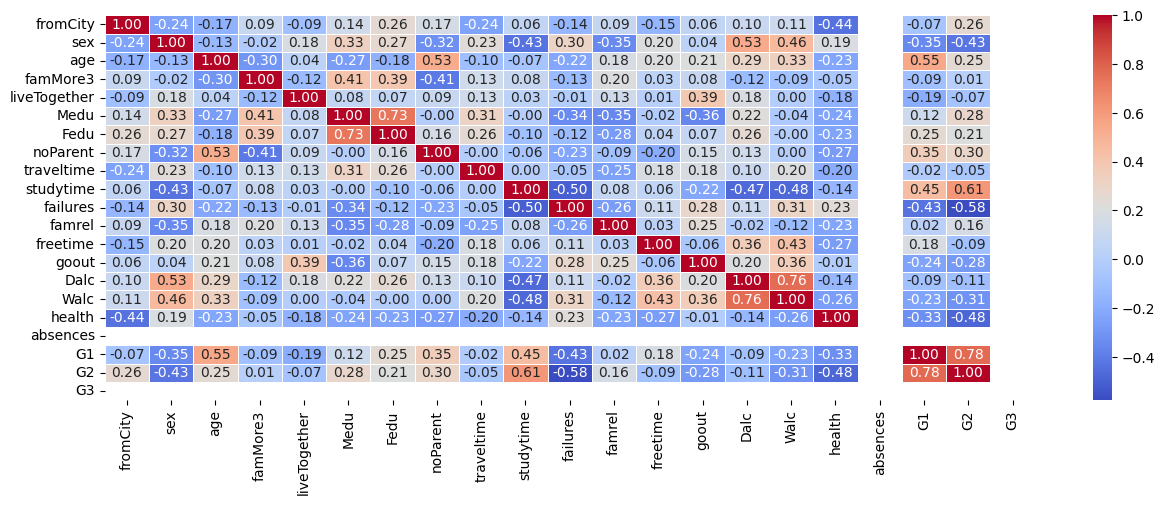

In [204]:
plt.figure(figsize=(15, 5))
sns.heatmap(data=only_no_g3.corr(numeric_only=True), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

### 시험 안본 사람은 drop한 사람임. 그래서 absences 기록이 사라짐 &rarr; 시험 안본 사람들 제거

In [205]:
print(gp_df[gp_df['G3'] == 0]['absences'].sum())

0


In [206]:
# 시험 안본 사람들 제거
gp_df = gp_df[gp_df['G3'] > 0]

In [207]:
gp_df.columns

Index(['fromCity', 'sex', 'age', 'famMore3', 'liveTogether', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'noParent', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

### 부모직업에 others가 많음. 일단은 빼보는거로 결정

In [208]:
gp_df['Mjob'].value_counts(), gp_df['Fjob'].value_counts()

(Mjob
 other       111
 services     86
 teacher      48
 at_home      40
 health       30
 Name: count, dtype: int64,
 Fjob
 other       177
 services     83
 teacher      24
 health       18
 at_home      13
 Name: count, dtype: int64)

In [209]:
# 부모직업 제거
gp_df = gp_df.drop(columns=['Mjob', 'Fjob'])

In [210]:
gp_df['reason'].value_counts()

reason
course        107
reputation     95
home           86
other          27
Name: count, dtype: int64

### 학교 다니는 이유는 course, reputation, home, other 이렇게 4개임. 이유별로 학생을 그룹화하고 그룹별로 3개 시험 평균값을 보면 차이가 없음. 즉, 성적 예측이 reasons는 의미가 없다 생각

In [211]:
reasons = gp_df['reason'].unique()

for re in reasons:
    temp = gp_df[gp_df['reason'] == re]
    print((temp['G1'] + temp['G2'] + temp['G3']).mean() / 3)

11.199376947040498
11.296296296296296
11.523255813953488
11.72982456140351


##### 상위 25%, 하위 25%별 학교선택 이유를 보면 차이는 존재하나 매우 미미하고 표본도 적음. 일단 제거

In [212]:
above_q3 = gp_df[gp_df['G3'] >= gp_df['G3'].quantile(0.75)]
low_q1 = gp_df[gp_df['G3'] <= gp_df['G3'].quantile(0.25)]

print('성적 상위 25% 학생들 학교선택 이유')
for v, c in above_q3['reason'].value_counts().items():
    print(v, c, '\b%')
print('\n성적 하위 25% 학생들 학교선택 이유')
for v, c in low_q1['reason'].value_counts().items():
    print(v, c, '\b%')

성적 상위 25% 학생들 학교선택 이유
reputation 35%
course 26%
home 24%
other 8%

성적 하위 25% 학생들 학교선택 이유
course 30%
reputation 22%
home 20%
other 7%


In [213]:
# reason 컬럼 삭제
gp_df = gp_df.drop(columns=['reason'])

In [214]:
gp_df.columns

Index(['fromCity', 'sex', 'age', 'famMore3', 'liveTogether', 'Medu', 'Fedu',
       'noParent', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health',
       'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [215]:
print(f'전체컬럼수: {len(gp_df.columns)}')
print(f'숫자형 아닌 컬럼수: {len(gp_df.select_dtypes(include=['object']).columns)}')
print(f'숫자형 컬럼수: {len(gp_df.select_dtypes(include=['int']).columns)}')

전체컬럼수: 29
숫자형 아닌 컬럼수: 8
숫자형 컬럼수: 21


In [216]:
# Str타입으로 된 Yes/No값가진 컬럼들을 전부 0 or 1을 가진 int로 바꿈
not_num_cols = gp_df.select_dtypes(include=['object']).columns

# 숫자형 아닌 컬럼들 표시
print(not_num_cols)

for col in not_num_cols:
    gp_df[col] = gp_df[col].apply(lambda x: 1 if x == 'yes' or x == 'Yes' else 0)

Index(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic'],
      dtype='object')


In [217]:
# 숫자형 아닌 컬럼들 없음 이제
gp_df.select_dtypes(include=['object']).columns

Index([], dtype='object')

### 원랜 T/F는 bool타입으로 저장하려 했으나 csv 저장하고 다시 불러올 때 str타입으로 바뀌는 점 때문에 int형으로 유지함.
- str타입 아니게 불러오는 방법이 있으나 그럴거면 애초에 bool타입 아닌거로 저장하는게 편함

In [218]:
# # 0, 1로만 이루어진 컬럼, 즉 bool타입이어야 할 컬럼들을 bool로 변환
# for col in gp_df.columns:
#     if set(gp_df[col].unique()) <= {0, 1}:
#         gp_df[col] = gp_df[col].astype(bool)

### DecisionTreeRegressor, RandomForestRegressor, XGBoost, LightGBM 같은 트리계열 모델을 쓴다면 스케일링 필요없음. 

<Axes: >

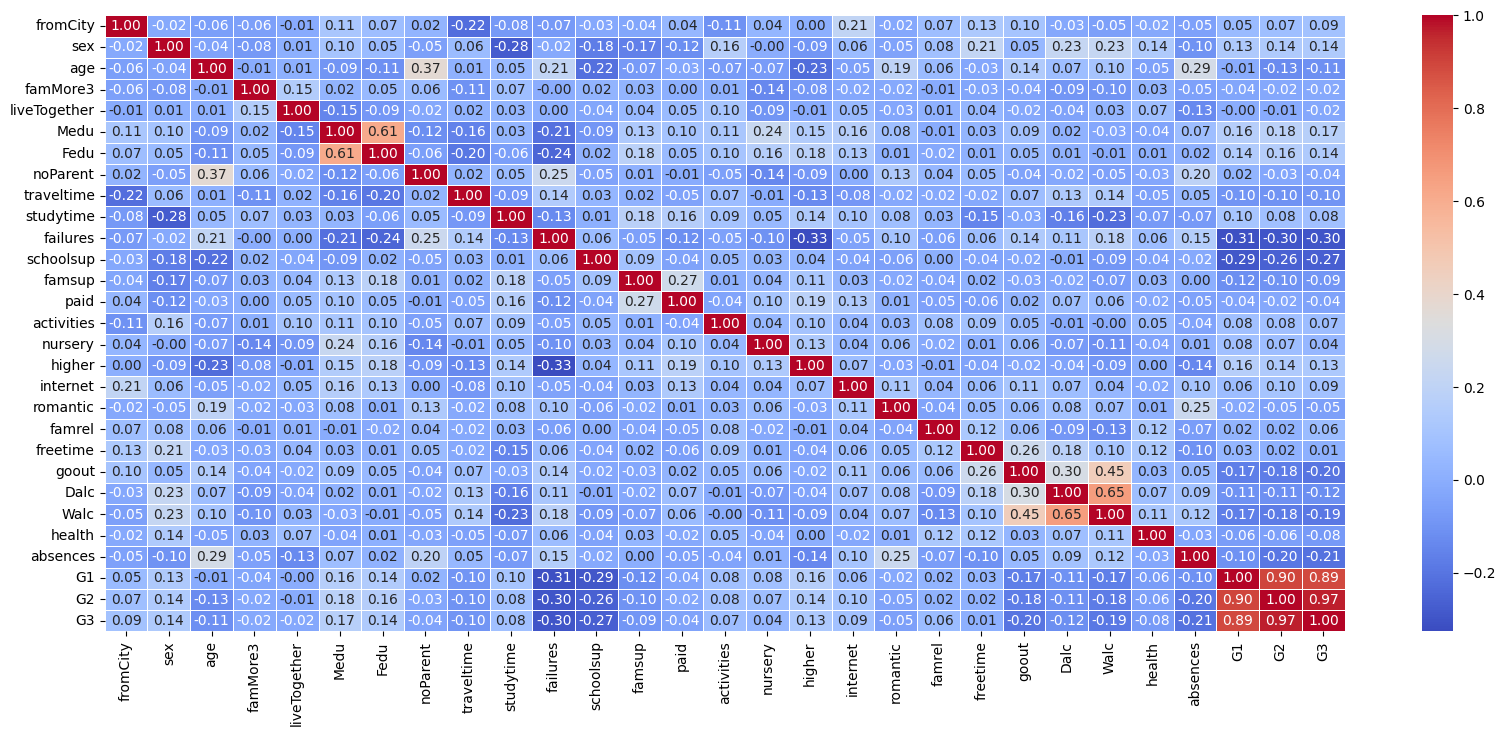

In [219]:
plt.figure(figsize=(20, 8))
sns.heatmap(data=gp_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

### 점수만 정규분포로 만들기

Text(0.5, 1.0, 'Gs Distribution')

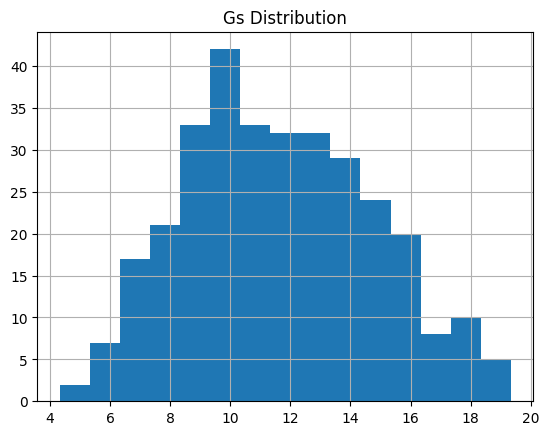

In [220]:
g_mean = ((gp_df['G1'] + gp_df['G2'] + gp_df['G3']) / 3)
g_mean.hist(bins=15)
plt.title('Gs Distribution')

Text(0.5, 1.0, 'G3 Distribution')

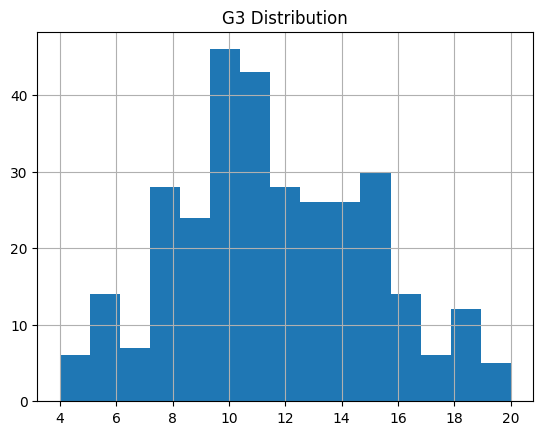

In [221]:
gp_df['G3'].hist(bins=15)
plt.title('G3 Distribution')

### 스케일링 전 데이터프레임 저장하기

In [222]:
gp_df.head(1)

,fromCity,sex,age,famMore3,liveTogether,Medu,Fedu,noParent,traveltime,studytime,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,18,1,0,4,4,0,2,2,...,4,3,4,1,1,3,6,5,6,6


In [223]:
# 
gp_df.to_csv('before_scaling.csv', index=False)

## standard scaling 하기
### G3는 라벨로 쓸 것이기에 데이터 연관성 분석 때만 scaling하고 ML 단계에선 원래 값으로 바꿔야 함.

In [224]:
# scaling 하기
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_Gs_df = pd.DataFrame()
scaled_Gs_df['G1'] = gp_df['G1']
scaled_Gs_df['G2'] = gp_df['G2']
scaled_Gs_df['G3'] = gp_df['G3']

scaled_Gs_data = scaler.fit_transform(scaled_Gs_df)
scaled_Gs_df = pd.DataFrame(scaled_Gs_data, columns=scaled_Gs_df.columns)
scaled_df = gp_df
scaled_df['G1'] = scaled_Gs_df['G1']
scaled_df['G2'] = scaled_Gs_df['G2']
scaled_df['G3'] = scaled_Gs_df['G3']

<Axes: >

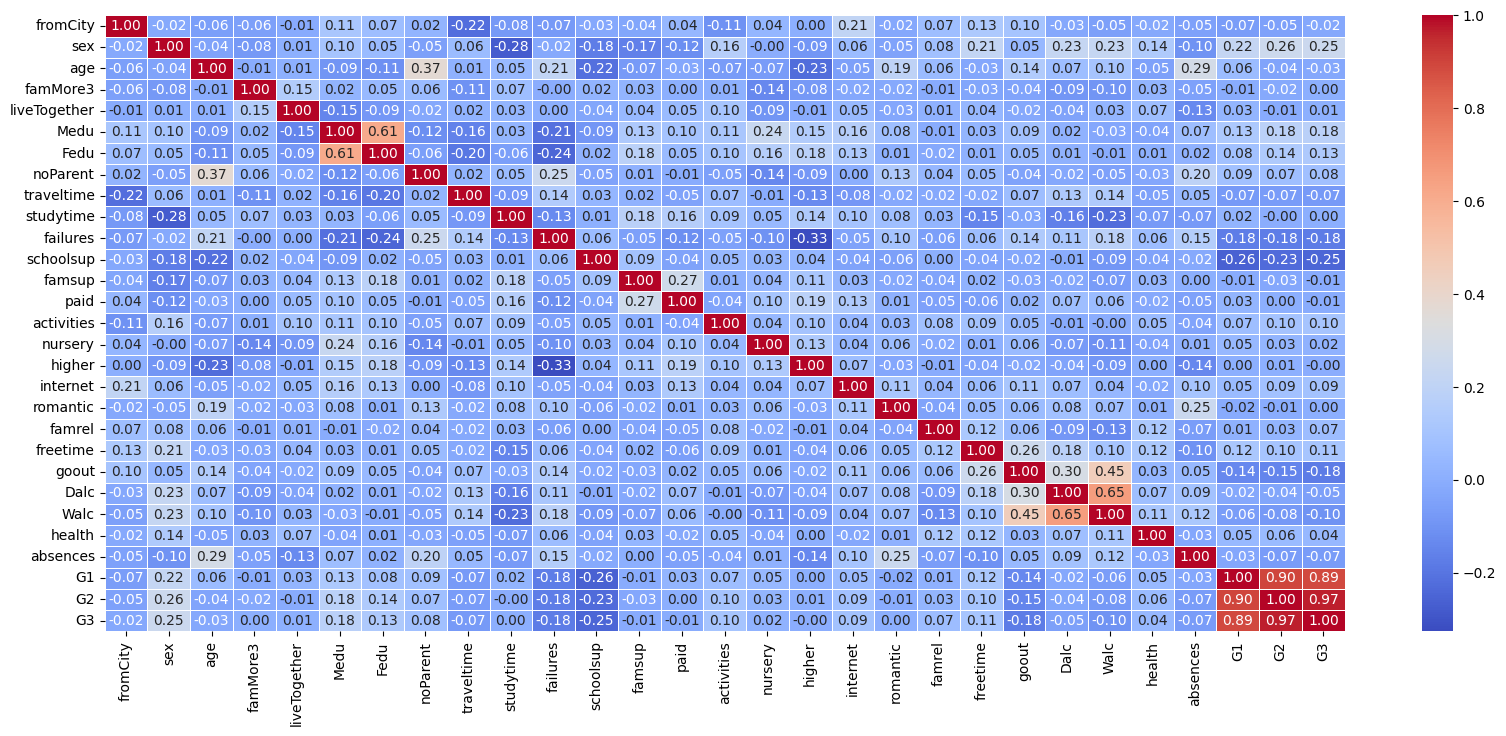

In [225]:
plt.figure(figsize=(20, 8))
sns.heatmap(data=scaled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.6)

In [ ]:
gp_df.to_csv('after_scaling.csv', index=False)